# important: This notebook is used as baseline for bliss paper!!! make sure you setup rail through https://rail-hub.readthedocs.io/en/latest/source/installation.html. and run cooresponding environment instead of bliss

# RAIL Estimation Tutorial Notebook

**Authors:** Sam Schmidt, Eric Charles, Alex Malz, others...

**Last run successfully:** August 15, 2023

This is a notebook demonstrating some of the `estimation` features of the LSST-DESC `RAIL`-iverse packages.  

The `rail.estimation` subpackage contains infrastructure to run multiple production-level photo-z codes.  There is a minimimal superclass that sets up some file paths and variable names. Each specific photo-z code resides in a subclass in `rail.estimation.algos` with algorithm-specific setup variables.  More extensive documentation is available on Read the Docs here:
https://rail-hub.readthedocs.io/en/latest/



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [3]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

We'll start by setting up the `DataStore`.  RAIL uses [`ceci`](https://github.com/LSSTDESC/ceci) as a back-end for pipelines of RAIL stages run at the command line. The `DataStore` is a workaround to enable `ceci` to interact with data files in an interactive notebook environment.   Some files will appear in the `DataStore` with the prefix "inprogress_" as they are stored in memory for use in the notebook, but the data will also be written out to file with the prefix "output_".  See the Golden Spike end-to-end demo notebook for more details on the `DataStore`.

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Importing all available estimators

There is some handy functionality in `rail.stages` to import all available stages that are installed in your environment.  `RailStage` knows about all of the sub-types of stages.  By looping through the values in  the `RailStage.pipeline_stages` dictionary, we can isolate those that are sub-classes of `rail.estimation.estimator.CatEstimator`, which operate on catalog-like inputs.  Let's run this `import_and_attach_all()` command, and then print out the subclasses that are now available for use (though in this demo we only take advantage of two specific estimators):

In [5]:
import rail.stages
rail.stages.import_and_attach_all()

for val in RailStage.pipeline_stages.values():
    if issubclass(val[0], rail.estimation.estimator.CatEstimator):
        print(val[0])

Imported rail.hub
Imported rail.astro_tools
Imported rail.core
Imported rail.stages
Imported rail.bpz
Imported rail.cmnn
Failed to import rail.delight because: No module named 'rail.estimation.algos.delightPZ'


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Imported rail.dsps
Imported rail.flexzboost
Install FSPS with the following commands:
pip uninstall fsps
git clone --recursive https://github.com/dfm/python-fsps.git
cd python-fsps
python -m pip install .
export SPS_HOME=$(pwd)/src/fsps/libfsps

Imported rail.fsps
Imported rail.gpz
Imported rail.pipelines
Imported rail.pzflow
Imported rail.sklearn
Imported rail.som
Attached 12 base classes and 75 fully formed stages to rail.stages
<class 'rail.estimation.estimator.CatEstimator'>
<class 'rail.estimation.algos.random_gauss.RandomGaussEstimator'>
<class 'rail.estimation.algos.train_z.TrainZEstimator'>
<class 'rail.estimation.algos.bpz_lite.BPZliteEstimator'>
<class 'rail.estimation.algos.cmnn.CMNNEstimator'>
<class 'rail.estimation.algos.flexzboost.FlexZBoostEstimator'>
<class 'rail.estimation.algos.gpz.GPzEstimator'>
<class 'rail.estimation.algos.pzflow_nf.PZFlowEstimator'>
<class 'rail.estimation.algos.k_nearneigh.KNearNeighEstimator'>
<class 'rail.estimation.algos.sklearn_neurnet.SklNe

You should see a list of the available subclasses corresponding to specific photo-z algorithms, as printed out above.  These currently include:

- `bpz_lite` is a template-based code that outputs the posterior estimated given a specific template set and Bayesian prior. See [Benitez (2000)](http://stacks.iop.org/0004-637X/536/i=2/a=571) for more details.
- `cmnn` is an implementation of the "colour-matched nearest neighbour` estimator described in [Graham et al 2018](https://ui.adsabs.harvard.edu/abs/2018AJ....155....1G/abstract).  It returns a single Gaussian for each galaxy.
- `delight_hybrid` (currently `delightPZ`) is a hybrid gaussian process/template-based code. See the [Leistedt & Hogg (2017)](https://doi.org/10.3847%2F1538-3881%2Faa91d5) for more details.
- `flexzboost` is a fully functional photo-z algorithm, implementing the FlexZBoost conditional density estimate method from [Izbicki, Lee & Freeman (2017)](https://doi.org/10.1214/16-AOAS1013) that performed well in the LSST-DESC Photo-Z Data Challenge 1 paper ([Schmidt, Malz & Soo, et al. (2020)](https://academic.oup.com/mnras/article/499/2/1587/5905416)).  FlexZBoost and some specialized metrics for it are available in Python and R through [FlexCode](https://github.com/lee-group-cmu/FlexCode).
- `gpz` is a Gaussian Process-based estimator. See [Almosallam et al 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.462..726A/abstract) for details on the algorithm.  It currently returns a single Gaussian for each PDF.
- `k_nearneigh` is a simple implementation of a weighted k-nearest neighbor photo-z code. It stores each PDF as a weighted sum of Gaussians based on the distance from neighbors in color-space.<br>
- `pzflow_nf` uses the same normalizing flow code [pzflow](https://github.com/jfcrenshaw/pzflow), the same one that appears in `rail.creation`, to predict redshift PDFs.
- `random_gauss` is a very simple class that does not actually predict a meaningful photo-z but can be useful for quick null tests when developing a pipeline. Instead it produces a randomly drawn Gaussian for each galaxy.
- `sklearn_neurnet` is another toy model using `sklearn`'s neural network to predict a point estimate redshift from the training data, then assigns a sigma width based on the estimated redshift.
- `trainz` is our "pathological" estimator. It makes a PDF from a histogram of the training data and assigns that PDF to every galaxy without considering its photometry.


Each code should have two specific classes associated with it: one to `inform()` using a set of training data or explicit priors and one to `estimate()` the per-galaxy photo-z PDFs.  These should be imported from the `src/rail/estimation/algos/[name_of_code]` module using the above names. The naming pattern is `[NameOfCode]Estimator` for the estimating class, and `[NameOfCode]Informer` for the training/ingesting class, for example `FlexZBoostEstimator` and  `FlexZBoostInformer`.  

For each of these two classes, we follow the pattern to first run a `make_stage()` method for the class in order to set up the `ceci` infrastructure and then invoke the `inform()` or `estimate()` method for the class in question.  We show examples of this below.

Now, let's load our training data, which is stored in hdf5 format.  We'll load it into the `DataStore` so that the `ceci` stages are able to access it.

In [6]:
from rail.utils.path_utils import find_rail_file
trainFile = os.path.abspath("/data/scratch/qiaozhih/data/redshift/dc2/rail_train_lsst_2000k.hdf5")
testFile = os.path.abspath("/data/scratch/qiaozhih/data/redshift/dc2/rail_test_lsst.hdf5")

training_data = DS.read_file("training_data", TableHandle, trainFile)
test_data = DS.read_file("test_data", TableHandle, testFile)

In [7]:
zgrid = np.linspace(0, 3., 301)

## FlexZBoost

That illustrates the basics. Now let's try the `FlexZBoostEstimator` estimator.  FlexZBoost is available in the [rail_flexzboost](https://github.com/LSSTDESC/rail_flexzboost/) repo and can be installed with

`pip install pz-rail-flexzboost`

on the command line or from source.  Once installed, it will function the same as any of the other estimators included in the primary `rail` repo.

`FlexZBoostEstimator` approximates the conditional density estimate for each PDF with a set of weights on a set of basis functions.  This can save space relative to a gridded parameterization, but it also leads to residual "bumps" in the PDF intrinsic to the underlying cosine or fourier parameterization.  For this reason, `FlexZBoostEstimator` has a post-processing stage where it "trims" (i.e. sets to zero) any small peaks, or "bumps", below a certain `bump_thresh` threshold.

One of the dominant features seen in our PhotoZDC1 analysis of multiple photo-z codes (Schmidt, Malz et al. 2020) was that photo-z estimates were often, in general, overconfident or underconfident in their overall uncertainty in PDFs.  To remedy this, `FlexZBoostEstimator` has an additional post-processing step where it applies a "sharpening" parameter `sharpen` that modulates the width of the PDFs according to a power law.

A portion of the training data is held in reserve to determine best-fit values for both `bump_thresh` and `sharpening`, which we currently find by simply calculating the CDE loss for a grid of `bump_thresh` and `sharpening` values; once those values are set FlexZBoost will re-train its density estimate model with the full dataset. A more sophisticated hyperparameter fitting procedure may be implemented in the future.

We'll start with a dictionary of setup parameters for FlexZBoostEstimator, just as we had for the k-nearest neighbor estimator.  Some of the parameters are the same as in k-nearest neighbor above, `zmin`, `zmax`, `nzbins`.  However, FlexZBoostEstimator performs a more in depth training and as such has more input parameters to control its behavior.  These parameters are:

- `basis_system`: which basis system to use in the density estimate. The default is `cosine` but `fourier` is also an option
- `max_basis`: the maximum number of basis functions parameters to use for PDFs
- `regression_params`: a dictionary of options fed to `xgboost` that control the maximum depth and the `objective` function.  An update in `xgboost` means that `objective` should now be set to `reg:squarederror` for proper functioning.
- `trainfrac`: The fraction of the training data to use for training the density estimate.  The remaining galaxies will be used for validation of `bump_thresh` and `sharpening`.
- `bumpmin`: the minimum value to test in the `bump_thresh` grid
- `bumpmax`: the maximum value to test in the `bump_thresh` grid
- `nbump`: how many points to test in the `bump_thresh` grid
- `sharpmin`, `sharpmax`, `nsharp`: same as equivalent `bump_thresh` params, but for `sharpening` parameter

In [8]:
fz_dict = dict(zmin=0.0, zmax=3.0, nzbins=301,
               trainfrac=0.75, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=35, basis_system='cosine',
               hdf5_groupname='photometry',
               regression_params={'max_depth': 8,'objective':'reg:squarederror'})
fz_modelfile = 'demo_FZB_model_2000k.pkl'

In [9]:
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile, **fz_dict)

`FlexZBoostInformer` operates on the training set and writes a file containing the estimation model.  `FlexZBoost` uses xgboost to determine a conditional density estimate model, and also fits the `bump_thresh` and `sharpen` parameters described above.

`FlexZBoost` is a bit more sophisticated than the earlier k-nearest neighbor estimator, so it will take a bit longer to train, but not drastically so, still under a minute on a semi-new laptop.  We specified the name of the model file, `demo_FZB_model.pkl`, which will store our trained model for use with the estimation stage.

In [10]:
%%time
inform_pzflex.inform(training_data)

stacking some data...
read in training data
fit the model...


/home/qiaozhih/rail/.env/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/home/qiaozhih/rail/.env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:12:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/qiaozhih/rail/.env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:12:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/qiaozhih/rail/.env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:12:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/home/qiaozhih/rail/.env/lib/python3.10/site-packages/xgboost/core.py:158: UserWa

## Loading a pre-trained model

If we have an existing pretrained model, for example the one in the file `demo_FZB_model.pkl`, we can skip this step in subsequent runs of an estimator; that is, we load this pickled model without having to repeat the training stage for this specific training data, and that can save time for larger training sets that would take longer to create the model.

There are two supported model output representations, `interp` (default) and `flexzboost`. Using `flexzboost` will store the output basis function weights from FlexCode, resulting in a smaller storage size on disk and giving the user the option to tune the sharpening and bump-removal parameters as a post-processing step. However, if you know that you will be performing operations on PDFs evaluated on a redshift grid that is known before performing the estimation, you can peform that post-processing up front by employing `interp` to store the output as interpolated y values for a given set of x values, requiring more storage space but eliminating the need to evaluate the PDFs upon downstream usage. 

For additional comparisons of the approaches, see the documentation for `qp_flexzboost` here: https://qp-flexzboost.readthedocs.io/en/latest/source/performance_comparison.html

In [10]:
# %%time
pzflex = FlexZBoostEstimator.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model', allow_missing=True))

# For this notebook, we will use the default value of qp_representation as shown
# above due to the additional computation time that would be required in the
# later steps when working with the flexzboost representation.
# Below are two examples showing the explicit use of the qp_representation argument.
"""
pzflex = FlexZBoostEstimator.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model'),
                            qp_representation='interp')

pzflex = FlexZBoostEstimator.make_stage(name='fzboost', hdf5_groupname='photometry',
                            model=inform_pzflex.get_handle('model'),
                            qp_representation='flexzboost')
"""

Inserting handle into data store.  model_inform_fzboost: inprogress_demo_FZB_model_2000k.pkl, inform_fzboost


"\npzflex = FlexZBoostEstimator.make_stage(name='fzboost', hdf5_groupname='photometry',\n                            model=inform_pzflex.get_handle('model'),\n                            qp_representation='interp')\n\npzflex = FlexZBoostEstimator.make_stage(name='fzboost', hdf5_groupname='photometry',\n                            model=inform_pzflex.get_handle('model'),\n                            qp_representation='flexzboost')\n"

It takes only a few seconds, so, if you are running an algorithm with a burdensome training requirement, saving a trained copy of the model for later repeated use can be a real time saver.

Now, let's compute photo-z's using with the `estimate` method.  

In [12]:
# %%time
fzresults = pzflex.estimate(test_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000


/home/qiaozhih/rail/.env/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Inserting handle into data store.  output_fzboost: inprogress_output_fzboost.hdf5, fzboost
Process 0 running estimator on chunk 10000 - 20000
Process 0 estimating PZ PDF for rows 10,000 - 20,000
Process 0 running estimator on chunk 20000 - 30000
Process 0 estimating PZ PDF for rows 20,000 - 30,000
Process 0 running estimator on chunk 30000 - 40000
Process 0 estimating PZ PDF for rows 30,000 - 40,000
Process 0 running estimator on chunk 40000 - 50000
Process 0 estimating PZ PDF for rows 40,000 - 50,000
Process 0 running estimator on chunk 50000 - 60000
Process 0 estimating PZ PDF for rows 50,000 - 60,000
Process 0 running estimator on chunk 60000 - 70000
Process 0 estimating PZ PDF for rows 60,000 - 70,000
Process 0 running estimator on chunk 70000 - 80000
Process 0 estimating PZ PDF for rows 70,000 - 80,000
Process 0 running estimator on chunk 80000 - 90000
Process 0 estimating PZ PDF for rows 80,000 - 90,000
Process 0 running estimator on chunk 90000 - 100000
Process 0 estimating PZ P

We can calculate the median and mode values of the PDFs and plot their distribution (in this case the modes are already stored in the qp.Ensemble's ancillary data, but here is an example of computing the point estimates via qp directly):

In [13]:
fz_medians = fzresults().median()
fz_modes = fzresults().mode(grid=zgrid)

We can also plot a point estimaten against the truth as a visual diagnostic:

Text(0, 0.5, 'estimated photoz')

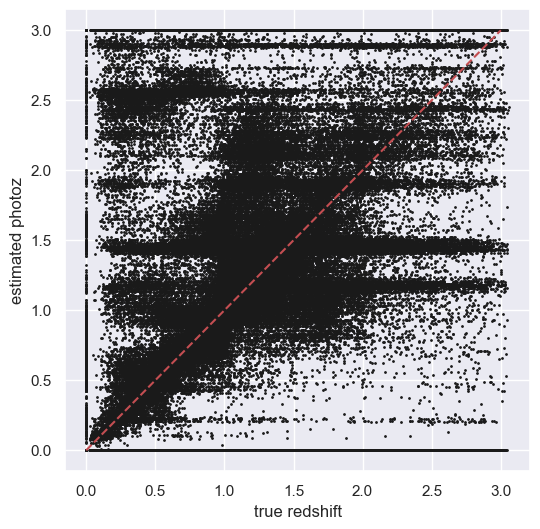

In [14]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(6,6))
plt.scatter(test_data()['photometry']['redshift'],fz_modes,s=1,c='k')
plt.plot([0,3],[0,3],'r--')
plt.xlabel("true redshift")
plt.ylabel("estimated photoz")
# plt.savefig('train_2000k_gt_testset.pdf')

In [16]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_data()['photometry']['redshift'], fz_modes)

np.float64(0.6649825424164433)

## metrics for evaluation

In [20]:
import pandas as pd
rail_df = pd.DataFrame({
    "true_red": test_data()['photometry']['redshift'],
    "est_red": fz_modes.squeeze(-1),
    "mag_r": test_data()['photometry']['mag_r_lsst'],
    "id": test_data()['photometry']['objid'],
    "blendedness": test_data()['photometry']['blendedness'],
})

In [21]:
test_data()['photometry'].keys()

odict_keys(['blendedness', 'mag_g_lsst', 'mag_i_lsst', 'mag_r_lsst', 'mag_u_lsst', 'mag_y_lsst', 'mag_z_lsst', 'magerr_g_lsst', 'magerr_i_lsst', 'magerr_r_lsst', 'magerr_u_lsst', 'magerr_y_lsst', 'magerr_z_lsst', 'objid', 'redshift'])

In [22]:
mag_bins = [-np.inf, 23.9, 24.1, 24.5, 24.9, 25.6, np.inf]
mag_labels = ["<23.9", "23.9-24.1", "24.1-24.5", "24.5-24.9", "24.9-25.6", ">25.6"]
true_red_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, np.inf]
true_red_labels = ["<0.5", "0.5-1.0", "1.0-1.5", "1.5-2.0", "2.0-2.5", "2.5-3.0",">3.0"]
blendedness_bins = [-np.inf ,0.0001, 0.02, 0.1, 0.2, 0.6, np.inf]
blendedness_labels = ["<0.0001", "0.0001-0.02", "0.02-0.1", "0.1-0.2", "0.2-0.6",">0.6"]
rail_df['mag_bins'] = pd.cut(rail_df['mag_r'], bins=mag_bins, labels=mag_labels, include_lowest=True)
rail_df['true_red_bins'] = pd.cut(rail_df['true_red'], bins=true_red_bins, labels=true_red_labels, include_lowest=True)
rail_df['blendedness_bins'] = pd.cut(rail_df['blendedness'], bins=blendedness_bins, labels=blendedness_labels, include_lowest=True)

def calculate_mse(group):
    return ((group['true_red'] - group['est_red']) ** 2).mean()

def calculate_outlier_fraction(group):
    metric_outlier = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    num_outlier = (metric_outlier > 0.15).sum()
    return num_outlier / len(metric_outlier)

def calculate_outlier_fraction_cata(group):
    metric_outlier = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    num_outlier = (metric_outlier > 1).sum()
    return num_outlier / len(metric_outlier)

def calculate_nmad(group):
    metric = (group['true_red'] - group['est_red']) / (1 + group['true_red'])
    bias = np.median(metric)
    nmad_all = np.abs(metric - bias)
    nmad = 1.4826 * np.median(nmad_all)
    return nmad

def calculate_bias_abs(group):
    metric = np.abs(group['true_red'] - group['est_red']) / (1 + group['true_red'])
    return np.median(metric)

In [23]:
out_dir = "/data/scratch/qiaozhih/data/redshift/metrics_result"
os.makedirs(out_dir, exist_ok=True)

In [24]:
# mag
mse_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_mse).reset_index(name='mse')
outlier_fraction_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_outlier_fraction).reset_index(name='outlier_fraction')
outlier_fraction_cata_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_outlier_fraction_cata).reset_index(name='outlier_fraction')
nmad_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_nmad).reset_index(name='nmad')
bias_abs_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_bias_abs).reset_index(name='bias_abs')
merged_df = mse_by_mag_range.merge(outlier_fraction_by_mag_range, on='mag_bins')
merged_df = merged_df.merge(outlier_fraction_cata_by_mag_range, on='mag_bins', suffixes=('', '_cata'))
merged_df = merged_df.merge(nmad_by_mag_range, on='mag_bins')


/tmp/ipykernel_1029249/660124161.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_mse).reset_index(name='mse')
/tmp/ipykernel_1029249/660124161.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_mag_range = rail_df.groupby('mag_bins').apply(calculate_mse).reset_index(name='mse')
/tmp/ipykernel_1029249/660124161.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pa

In [25]:
save_path = os.path.join(out_dir, "lsst_flexzboost_metrics_mag.csv")
if os.path.exists(save_path):
    metrics_df_stratified_by_mag = merged_df.merge(bias_abs_by_mag_range, on='mag_bins')
    metrics_df_stratified_by_mag.to_csv(save_path)
else:
    metrics_df_stratified_by_mag = pd.read_csv(save_path, index_col=0)

In [26]:
metrics_df_stratified_by_mag

,mag_bins,mse,outlier_fraction,outlier_fraction_cata,nmad,bias_abs
0,<23.9,0.312682,0.137891,0.039014,0.029221,0.020070
1,23.9-24.1,0.537919,0.232978,0.071344,0.056320,0.038440
2,24.1-24.5,0.568038,0.248760,0.073940,0.062480,0.042392
3,24.5-24.9,0.616942,0.301162,0.077630,0.080132,0.054845
4,24.9-25.6,0.708274,0.398283,0.080509,0.133543,0.090257
5,>25.6,0.767819,0.551018,0.057545,0.276814,0.184987


In [27]:
# true red
save_path = os.path.join(out_dir, "lsst_flexzboost_metrics_truered.csv")
if os.path.exists(save_path):
    mse_by_true_red_range = rail_df.groupby('true_red_bins').apply(calculate_mse).reset_index(name='mse')
    mse_by_true_red_range.to_csv(save_path)
else:
    mse_by_true_red_range = pd.read_csv(save_path, index_col=0)

/tmp/ipykernel_1029249/1228670815.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_by_true_red_range = rail_df.groupby('true_red_bins').apply(calculate_mse).reset_index(name='mse')
/tmp/ipykernel_1029249/1228670815.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_true_red_range = rail_df.groupby('true_red_bins').apply(calculate_mse).reset_index(name='mse')


In [28]:
mse_by_true_red_range

,true_red_bins,mse
0,<0.5,1.464552
1,0.5-1.0,0.577115
2,1.0-1.5,0.267938
3,1.5-2.0,0.431604
4,2.0-2.5,1.056610
5,2.5-3.0,2.018993
6,>3.0,2.683679


In [29]:
# blendedness
save_path = os.path.join(out_dir, "lsst_flexzboost_metrics_blendedness.csv")
if os.path.exists(save_path):
    mse_by_blendedness_range = rail_df.groupby('blendedness_bins').apply(calculate_mse).reset_index(name='mse')
    mse_by_blendedness_range.to_csv(save_path)
else:
    mse_by_blendedness_range = pd.read_csv(save_path, index_col=0)

/tmp/ipykernel_1029249/958567973.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mse_by_blendedness_range = rail_df.groupby('blendedness_bins').apply(calculate_mse).reset_index(name='mse')
/tmp/ipykernel_1029249/958567973.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_blendedness_range = rail_df.groupby('blendedness_bins').apply(calculate_mse).reset_index(name='mse')


In [31]:
mse_by_blendedness_range

,blendedness_bins,mse
0,<0.0001,0.661265
1,0.0001-0.02,0.623434
2,0.02-0.1,0.697646
3,0.1-0.2,0.684080
4,0.2-0.6,0.680728
5,>0.6,0.764544
